In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries:

In [ ]:
!pip install category_encoders
!pip install scikit-optimize
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 5.4 MB/s 
     |████████████████████████████████| 135 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.5 MB/s 


In [ ]:
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import ( MinMaxScaler, StandardScaler, Normalizer, 
                                    OneHotEncoder )
from sklearn.linear_model import SGDRegressor

from xgboost import XGBRegressor

from scipy.sparse import hstack
from scipy import sparse

from functools import partial
from skopt.plots import plot_convergence
from skopt import gp_minimize
from skopt import space

import nltk
nltk.download('punkt')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
import keras_tuner as kt

from prettytable import PrettyTable
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import re

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading data and feature transformers:

In [ ]:
# data
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/df_train.csv", na_filter=False)
df_cv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/df_cv.csv", na_filter=False)

# Feature transformers
target_encoder = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/target_encoder.joblib")
one_hot_encoder = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/one_hot_encoder.joblib")
ctv_text = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/ctv_text.joblib")
tfv_text = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/tfv_text.joblib")
ctv_name_and_brand = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/ctv_name_and_brand.joblib")
tfv_name_and_brand = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/tfv_name_and_brand.joblib")
lasso_selected_features = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/lasso_selected_features.joblib")

In [ ]:
# dropping bins column, as it's not used anymore
train_bins = df_train["bins"]
df_train.drop("bins", axis=1, inplace=True)
df_cv.drop("bins", axis=1, inplace=True)

In [ ]:
df_train.columns

Index(['train_id', 'item_condition_id', 'shipping', 'main_cat', 'subcat_1',
       'subcat_2', 'missing_brand_name', 'missing_item_desc',
       'preproc_name_and_brand', 'preproc_text', 'log_price',
       'preproc_name_length', 'log_desc_length', 'combo_1_lg_pr_75_percentile',
       'combo_4_lg_pr_max', 'combo_8_lg_pr_max', 'combo_1_lg_pr_max',
       'combo_9_lg_pr_mean-median', 'brand_count', 'combo_3_lg_pr_min',
       'combo_4_lg_pr_25_percentile', 'combo_15_lg_pr_75_percentile',
       'combo_10_lg_pr_median', 'combo_7_lg_pr_mean', 'combo_7_lg_pr_median',
       'combo_11_lg_pr_mean-median', 'combo_6_lg_pr_25_percentile',
       'combo_11_lg_pr_mean', 'combo_5_lg_pr_25_percentile',
       'combo_14_lg_pr_mean', 'combo_12_lg_pr_75_percentile',
       'combo_1_lg_pr_25_percentile', 'name_word_count', 'name_length',
       'log_preproc_desc_word_count', 'combo_15_lg_pr_mean'],
      dtype='object')

# Separating features:

In [ ]:
# indicators
ind_cols = ['item_condition_id', 'missing_brand_name', 'missing_item_desc']
ind_cols_tr = df_train.loc[:, ind_cols].astype(int)
ind_cols_cv = df_cv.loc[:, ind_cols].astype(int)

# Categories and Shipping ID
cats_and_shipping = ['main_cat', 'subcat_1', 'subcat_2', 'shipping']
categories_shipping_tr = df_train.loc[:, cats_and_shipping]
categories_shipping_cv = df_cv.loc[:, cats_and_shipping]

# Preproc name
preproc_name_and_brand_tr = df_train.loc[:, ['preproc_name_and_brand']]
preproc_name_and_brand_cv = df_cv.loc[:, ['preproc_name_and_brand']]

# Preproc text
preproc_text_tr = df_train.loc[:, ['preproc_text']]
preproc_text_cv = df_cv.loc[:, ['preproc_text']]

# Other Engineered features:
other_eng_features = [feat for feat in lasso_selected_features 
                        if not feat.startswith("combo")]
other_eng_features_tr = df_train.loc[:, other_eng_features]
other_eng_features_cv = df_cv.loc[:, other_eng_features]

# group_by features
grp_by_features = [feat for feat in lasso_selected_features 
                    if feat.startswith("combo")]
group_by_feat_tr = df_train.loc[:, grp_by_features]
group_by_feat_cv = df_cv.loc[:, grp_by_features]

# Target column - price
log_price_tr = df_train.loc[:, ['log_price']]
price_cv = df_cv.loc[:, ['price']]

# Baseline Model:
Let's say the predicted price of a baseline model is equal to the mean of prices in the product's main category. The assumption is that the categories are predefined and available for every product.
If for some reason the product doesn't have the category information then the predicted will be equal to the mean of all prices in the data.

In [ ]:
# mean_log_price of the entire data
mean_log_price = df_train["log_price"].mean()

# mean_log_price for each main category
mean_log_price_category = df_train.groupby(["main_cat"]).agg(
    {"log_price": [np.mean]}).to_dict()[('log_price', 'mean')]

pred_baseline = df_cv["main_cat"].map(
    lambda x: np.expm1(mean_log_price_category.get(x, mean_log_price)))

print("Baseline RMSLE on cv split: ", mean_squared_log_error(
    df_cv["price"], pred_baseline, squared=False))

Baseline RMSLE on cv split:  0.7356616209151171


# Optimization function to be used by Bayesian Hyperparameter Optimization technique:
Library used: Scikit-Optimize

Ref: [AAAML](https://github.com/abhishekkrthakur/approachingalmost/blob/master/AAAMLP.pdf)

In [ ]:
def optimize(params, param_names, model_class, train_split, cv_split):
    """
    The main optimization function.
    This function takes all the arguments from the search space, training 
    features and targets. It then initializes the models by setting the chosen 
    parameters and runs cross-validation and returns a RMSLE value.

    :param params: list of params from gp_minimize
    :param param_names: list of param names. order is important!
    :param model_class: ML model class to initialize and train
    :param train_split: tuple(X, y) containing training data
    :param cv_split: tuple(X, y) containing cv data    
    :return: RMSLE on cv data
    """
    # initialize model with current parameters
    params = dict(zip(param_names, params))
    print("Input Params: ", params)
    model = model_class(**params)
    # loop over all folds
    X_tr, y_tr = train_split
    X_cv, y_cv = cv_split
    # fit model on train set
    model.fit(X_tr, y_tr)
    # create predictions
    preds_cv = model.predict(X_cv)
    preds_cv = np.abs(np.expm1(preds_cv))
    # calculate RMSLE on cv split
    cv_rmsle = mean_squared_log_error(y_cv, preds_cv, squared=False)
    # return cv_rmsle
    return cv_rmsle

In [ ]:
def tune_model(param_names, param_space, model_class, train_split, cv_split):
    """
    Tune a given model by solving the optimization function provided to obtain 
    optimal RMSE using skopt.
    
    :param param_names: list of param names. order is important!
    :param param_space: the param space to explore.
    :param model_class: ML model class to initialize and train.
    :param train_split: tuple(X, y) containing training data
    :param cv_split: tuple(X, y) containing cv data
    :return: best hyperparameters found.
    """
    # initialize optimize function partially
    optimization_function = partial(
        optimize,
        param_names = param_names,
        model_class = model_class,
        train_split = train_split,
        cv_split = cv_split,
    )

    # run gp_minize from sk-opt
    result = gp_minimize(optimization_function, dimensions=param_space, 
                        n_calls=30, n_initial_points=10,
                        n_jobs=-1, random_state=3, verbose=10)

    best_params = dict(
            zip(
                param_names,
                result.x
            )
        )
    return result, best_params

In [ ]:
def get_results(model_class, best_params, train_split, cv_split):
    """
    Train model using the best hyperparameters found and return the 
    results(RMSLE) on train and cv data.

    :param model_class: ML model class to train 
    :param best_params: Best Hyperparameters found for the model.
    :param train_split: tuple(X, y) containing training data
    :param cv_split: tuple(X, y) containing cv data
    :return: model results on train and cv data
    """ 
    X_tr, y_tr = train_split
    X_cv, y_cv = cv_split
    model = model_class(**best_params)
    model.fit(X_tr, y_tr)

    y_true_tr = np.expm1(y_tr)
    y_pred_tr = np.abs(np.expm1(model.predict(X_tr)))
    y_pred_cv = np.abs(np.expm1(model.predict(X_cv)))

    model_results = {}
    model_results["train"] = mean_squared_log_error(
                                            y_true_tr, y_pred_tr, squared=False)

    model_results["cv"] = mean_squared_log_error(
                                            y_cv, y_pred_cv, squared=False)

    return model_results

# Training on multiple datasets with different featurizations:
The idea is to diversify the vectorization of data along with diversifying the models for ensembling. 

ie; Train different models on different vectorizations of dataset. Allow the models to slightly overfit to reach different minima by means of different random model initializations and then by random order of the batches and size of batches(small and large) during training.

The combined ensemble model may give better results. (inspired from kaggle winner’s 
solution: [link](https://youtu.be/QFR0IHbzA30))

**Note:**
- Here slight overfitting of models is not tried explicitly as the above idea suggested, instead different hyper-parameter optimization techniques are tried out for experimentation. 
- Since the input has good number of samples and is a textual data, the number of dimensions are going to be high in the featurized data. Hence I restrain from trying tree based models such as Random Forest and Decision Trees. Tree based models could take lot of time and may not produce noticeable results in this case. 

## **Dataset Set 1**: 
One-Hot encoded categories and shipping_id, Ordinal encoded item_condition_id + TFIDF encoded text with bigrams and other numerical features obtained from feature engineering. 

In [ ]:
# will be used for storing best results of each model trained on dataset 1
ds1_model_results = {}
ds1_model_best_params = {}

# # saving the results on dataset-1
# joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
# joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

### TFIDF on name and text data:

In [ ]:
tfidf_text_tr = tfv_text.transform(preproc_text_tr['preproc_text'])
tfidf_text_cv = tfv_text.transform(preproc_text_cv['preproc_text'])

tfidf_name_and_brand_tr = tfv_name_and_brand.transform(
    preproc_name_and_brand_tr['preproc_name_and_brand'])
tfidf_name_and_brand_cv = tfv_name_and_brand.transform(
    preproc_name_and_brand_cv['preproc_name_and_brand'])

### One-Hot Encoding Categories and Shipping Id:

In [ ]:
enc_categories_shipping_tr = one_hot_encoder.transform(categories_shipping_tr)
enc_categories_shipping_cv = one_hot_encoder.transform(categories_shipping_cv)

In [ ]:
enc_categories_shipping_tr.shape

(1111245, 997)

### Scaling Data:

In [ ]:
min_max_scaler_1 = MinMaxScaler()

# train data to scale
scaled_features_tr = min_max_scaler_1.fit_transform(
    np.hstack((ind_cols_tr.values, other_eng_features_tr.values, 
                 group_by_feat_tr.values))
)

# cv data to scale
scaled_features_cv = min_max_scaler_1.transform(
    np.hstack((ind_cols_cv.values, other_eng_features_cv.values, 
                 group_by_feat_cv.values))
)

# saving the min_max_scaler object
joblib.dump(min_max_scaler_1, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/min_max_scaler_1.joblib")
del min_max_scaler_1

In [ ]:
X_tr_1 = hstack((scaled_features_tr, enc_categories_shipping_tr, 
                tfidf_name_and_brand_tr, tfidf_text_tr), format="csr")

X_cv_1 = hstack((scaled_features_cv, enc_categories_shipping_cv, 
                tfidf_name_and_brand_cv, tfidf_text_cv), format="csr")

In [ ]:
print(X_tr_1.shape)
print(X_cv_1.shape)

(1111245, 171883)
(370634, 171883)


### Ridge Regression (Linear Regression with L2 Regularization):

In [ ]:
# # loading the results on dataset-1
# ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
# ds1_model_beast_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for Ridge that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
]
param_names = [
    "alpha",
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
Ridge = partial(
    SGDRegressor,
    learning_rate='adaptive',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, Ridge, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 28.7513
Function value obtained: 0.5261
Current minimum: 0.5261
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 75.79547978890417}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 114.0303
Function value obtained: 0.7491
Current minimum: 0.5261
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 29.9186
Function value obtained: 0.5429
Current minimum: 0.5261
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 30.4440
Function value obtained: 0.7149
Current minimum: 0.5261
Iteration No: 5 started. Evaluating fun

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 25.9202
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00015942789708239314}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 26.0872
Function value obtained: 0.5125
Current minimum: 0.5036
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 26.0906
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 25.9252
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 26.0611
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 26.1371
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 106.68012417687818}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 903.2194
Function value obtained: 0.7493
Current minimum: 0.5036
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 25.9896
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1884230235610987}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 27.5245
Function value obtained: 0.6731
Current minimum: 0.5036
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 26.1223
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 3.119935925581212}
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 37.5192
Function value obtained: 0.7348
Current minimum: 0.5036
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 25.9799
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 25.8933
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 26.0172
Function value obtained: 0.5036
Current minimum: 0.5036
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 25.9914
Function value obtained: 0.5036
Current minimum: 0.5036


Best Hyperparams: {'alpha': 0.0001}


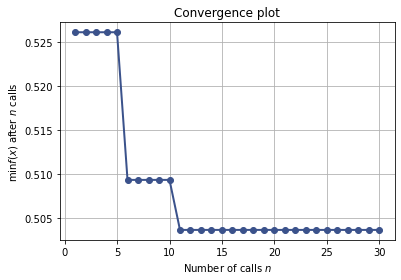

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "Ridge"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(Ridge, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from Ridge with dataset-1:  0.46653502352006665
CV RMSLE from Ridge with dataset-1:  0.5036320856886631


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### Lasso Regression (Linear Regression with L1 Regularization):

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for Lasso that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha")
]
param_names = [
    "alpha",
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
Lasso = partial(
    SGDRegressor,
    penalty='l1',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, Lasso, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.5204
Function value obtained: 0.5915
Current minimum: 0.5915
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 75.79547978890417}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.6687
Function value obtained: 0.7499
Current minimum: 0.5915
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.1291
Function value obtained: 0.6099
Current minimum: 0.5915
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.7643
Function value obtained: 0.7499
Current minimum: 0.5915
Iteration No: 5 started. Evaluating functi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 13.2337
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 22.603727905980342}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.0025
Function value obtained: 0.7499
Current minimum: 0.5691
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 13.3603
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 13.1842
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 13.1922
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 13.2474
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.34353625008349997}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.1074
Function value obtained: 0.7499
Current minimum: 0.5691
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 13.2017
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.04104416063745826}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.3024
Function value obtained: 0.7046
Current minimum: 0.5691
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 13.2724
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 13.2377
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 13.1386
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 13.2299
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 13.1038
Function value obtained: 0.5691
Current minimum: 0.5691
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 13.1683
Function value obtained: 0.5691
Current minimum: 0.5691


Best Hyperparams: {'alpha': 0.0001}


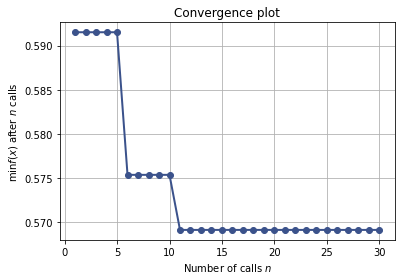

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "Lasso"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(Lasso, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from Lasso with dataset-1:  0.5308295491648114
CV RMSLE from Lasso with dataset-1:  0.5691278246464745


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### Elastic Net (Linear Regression with L1 and L2 Regularization):

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for Elastic Net that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0.0001, 0.9999, prior="uniform", name="l1_ratio")
]
param_names = [
    "alpha",
    "l1_ratio"
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
ElasticNet = partial(
    SGDRegressor,
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, ElasticNet, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8398810539636506}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.3705
Function value obtained: 0.5879
Current minimum: 0.5879
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197, 'l1_ratio': 0.5692974651691941}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.9929
Function value obtained: 0.5959
Current minimum: 0.5879
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.11466571841722528, 'l1_ratio': 0.01884425904870172}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.0902
Function value obtained: 0.6568
Current minimum: 0.5879
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24793871956659042}
Iteration No: 4 ended. Evaluation done 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.2740
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 13 started. Searching for the next optimal point.
Input Params:  {'alpha': 1000.0, 'l1_ratio': 0.0001}
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 14.2744
Function value obtained: 0.7499
Current minimum: 0.5373
Iteration No: 14 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010185363206912778, 'l1_ratio': 0.4695976650346544}
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.8010
Function value obtained: 0.5578
Current minimum: 0.5373
Iteration No: 15 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.2055
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 16 started. Searching for the next optimal point.
Input Params:  {'alpha': 979.9590184835157, 'l1_ratio': 0.9877076330085488}
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.2414
Function value obtained: 0.7499
Current minimum: 0.5373
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 7.421991046863035, 'l1_ratio': 0.0015841111997640085}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.8472
Function value obtained: 0.7447
Current minimum: 0.5373
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00048165809161098295, 'l1_ratio': 0.0020787055810234907}
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1226
Function value obtained: 0.5456
Current minimum: 0.53

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.5646
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010615926800494567, 'l1_ratio': 0.9896518699025939}
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 13.6187
Function value obtained: 0.5701
Current minimum: 0.5373
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.004326422409990975, 'l1_ratio': 0.0007317520247687813}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.5603
Function value obtained: 0.5792
Current minimum: 0.5373
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.1858
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.2449
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0030028835430934812, 'l1_ratio': 0.9978814125795199}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.9034
Function value obtained: 0.6381
Current minimum: 0.5373
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00012391278416998793, 'l1_ratio': 0.0001}
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.1882
Function value obtained: 0.5378
Current minimum: 0.5373
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.1602
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.5708
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.2449
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.1918
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.9634
Function value obtained: 0.5373
Current minimum: 0.5373


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0001}


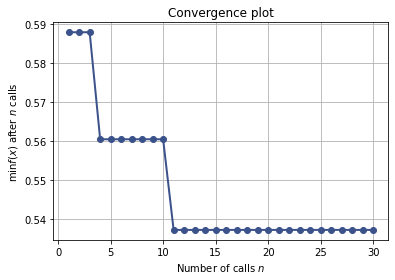

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "ElasticNet"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(ElasticNet, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from ElasticNet with dataset-1:  0.504342800316309
CV RMSLE from ElasticNet with dataset-1:  0.5372849039290916


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### Huber Regression:

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for Huber Regressor that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(1.1, 10, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
HuberRegressor = partial(
    SGDRegressor,
    loss='huber',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, HuberRegressor, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 2.179824372726423}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.3960
Function value obtained: 0.5882
Current minimum: 0.5882
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 1.266857276988843}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.7535
Function value obtained: 0.7502
Current minimum: 0.5882
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 1.9326083274424637}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.3797
Function value obtained: 0.5611
Current minimum: 0.5611
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 7.307

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.1345
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.2024
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 936.402622972326, 'l1_ratio': 0.0020330740734650914, 'epsilon': 1.4826776572954674}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 13.7356
Function value obtained: 0.7500
Current minimum: 0.5373
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.2022
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00962383767862763, 'l1_ratio': 0.0014209779280514037, 'epsilon': 7.02821156987909}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.9957
Function value obtained: 0.5934
Current minimum: 0.5373
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 6.968583618506019}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.2360
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.2281
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.5417848294848189, 'epsilon': 10.0}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.0415
Function value obtained: 0.5595
Current minimum: 0.5373
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.1749
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.9071
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 6.659990765212505}
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.1069
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 5.751395328286577}
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.1428
Function value obtained: 0.5373
Current minimum: 0.5373
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 7.635679655575222}
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.2547
Function value obtained: 0.5373
Current minimum: 0.5

Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


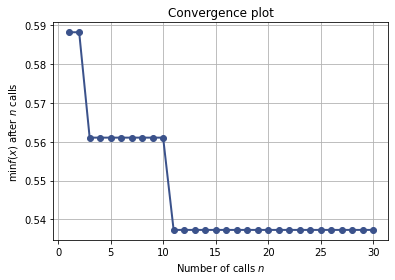

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "HuberRegressor"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(HuberRegressor, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from HuberRegressor with dataset-1:  0.504330973421856
CV RMSLE from HuberRegressor with dataset-1:  0.5372739146704751


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### SGD Regressor with loss="epsilon_insensitive":

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for SGD_epsilon_insensitive that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(0.1, 2, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
SGD_epsilon_insensitive = partial(
    SGDRegressor,
    loss='epsilon_insensitive',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, SGD_epsilon_insensitive, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 0.33052430428991053}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.6194
Function value obtained: 0.5895
Current minimum: 0.5895
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 0.13562121643582042}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.5148
Function value obtained: 0.7531
Current minimum: 0.5895
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 0.27774784518434614}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.3486
Function value obtained: 0.5600
Current minimum: 0.5600
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.1922
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.16786921489827533}
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1597
Function value obtained: 0.5368
Current minimum: 0.5360
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 1.0, 'epsilon': 0.9252600258002691}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 31.3901
Function value obtained: 0.5946
Current minimum: 0.5360
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.2051
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.001540643682201326, 'l1_ratio': 0.017238089522274683, 'epsilon': 0.11131539941026027}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.9701
Function value obtained: 0.5686
Current minimum: 0.5360
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 934.9005154637617, 'l1_ratio': 0.9533450216994945, 'epsilon': 1.1891758559697563}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.3965
Function value obtained: 0.7552
Current minimum: 0.5360
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.1336
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010409391161614022, 'l1_ratio': 0.9661663072555546, 'epsilon': 0.17998869132724876}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 14.2956
Function value obtained: 0.5659
Current minimum: 0.5360
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.1994
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.2445
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.1727
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.1982
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.1765
Function value obtained: 0.5360
Current minimum: 0.5360
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.1856
Function value obtained: 0.5360
Current minimum: 0.5360


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


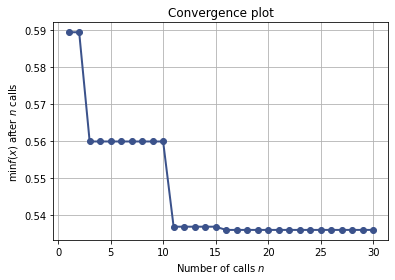

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "SGD_epsilon_insensitive"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(
    SGD_epsilon_insensitive, best_params, train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from SGD_epsilon_insensitive with dataset-1:  0.49989945362607535
CV RMSLE from SGD_epsilon_insensitive with dataset-1:  0.5360046725557169


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### SGD Regressor with loss="squared_epsilon_insensitive":

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
# define a parameter space for SGD_sq_epsilon_insensitive that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(0.1, 2, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_1, log_price_tr.values.ravel())
cv_split = (X_cv_1, price_cv.values.ravel())

# Model
SGD_sq_epsilon_insensitive = partial(
    SGDRegressor,
    loss='squared_epsilon_insensitive',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, SGD_sq_epsilon_insensitive, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 0.33052430428991053}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.6669
Function value obtained: 0.5864
Current minimum: 0.5864
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 0.13562121643582042}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.5233
Function value obtained: 0.7500
Current minimum: 0.5864
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 0.27774784518434614}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.2801
Function value obtained: 0.5552
Current minimum: 0.5552
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.0942
Function value obtained: 0.5255
Current minimum: 0.5255
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 993.4635444286149, 'l1_ratio': 0.029918674768730898, 'epsilon': 1.9830716275829667}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 18.2883
Function value obtained: 0.7803
Current minimum: 0.5255
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0018031733061492341, 'l1_ratio': 1.0, 'epsilon': 0.1}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 12.3685
Function value obtained: 0.6172
Current minimum: 0.5255
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.1760
Function value obtained: 0.5255
Current minimum: 0.5255
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.10618807205633092, 'l1_ratio': 0.9900730006657076, 'epsilon': 1.9636189000137163}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 6.0498
Function value obtained: 1.2490
Current minimum: 0.5255
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.8762420849861312}
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.0757
Function value obtained: 0.5857
Current minimum: 0.5255
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.001763937980594018, 'l1_ratio': 0.0, 'epsilon': 0.4221065317971723}
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.9495
Functi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.3097
Function value obtained: 0.5255
Current minimum: 0.5255
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00014104882927079023, 'l1_ratio': 0.0, 'epsilon': 0.1}
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.2068
Function value obtained: 0.5264
Current minimum: 0.5255
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.1409
Function value obtained: 0.5255
Current minimum: 0.5255
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.2090
Function value obtained: 0.5255
Current minimum: 0.5255


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


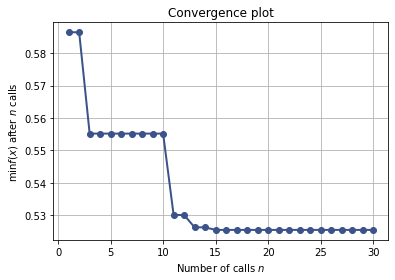

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "SGD_sq_epsilon_insensitive"
ds1_model_best_params[model_name] = best_params
ds1_model_results[model_name] = get_results(
    SGD_sq_epsilon_insensitive, best_params, train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from SGD_sq_epsilon_insensitive with dataset-1:  0.4918729260256391
CV RMSLE from SGD_sq_epsilon_insensitive with dataset-1:  0.525517463090408


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

### Simple MLPs:
Ref: [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

In [ ]:
def build_model(hp, params=None):
    inp = Input(shape=(X_tr_1.shape[1],), dtype='float32', sparse=True)
    
    if params is None:
        # Choose an optimal value between 32-256
        hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
        hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
        hp_units3 = hp.Int('units3', min_value=32, max_value=256, step=32)
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    else:
        hp_units1 = params['units1']
        hp_units2 = params['units2']
        hp_units3 = params['units3']
        hp_learning_rate = params['learning_rate']

    hidden_1 = Dense(units=hp_units1, kernel_initializer= 'he_uniform', 
                     activation='relu')(inp)
    hidden_2 = Dense(units=hp_units2, kernel_initializer= 'he_uniform', 
                     activation='relu')(hidden_1)
    hidden_3 = Dense(units=hp_units3, kernel_initializer= 'he_uniform', 
                     activation='relu')(hidden_2)
    out = Dense(1, kernel_initializer='normal', activation='linear')(hidden_3)
    mlp_ds1 = Model(inp, out)

    mlp_ds1.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='huber_loss',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return mlp_ds1

# BayesianOptimization algorithm from keras tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_rmse', direction="min"),
    max_trials=6,
    num_initial_points=3,
    seed=3,
    directory='mlp_ds1',
    project_name='Mercari_Price_Pred'
)

tuner.search(X_tr_1, log_price_tr.values.ravel(), epochs=3, batch_size=256,
             validation_data=(X_cv_1, np.log1p(price_cv.values)))

Trial 6 Complete [00h 02m 04s]
val_rmse: 0.44195133447647095

Best val_rmse So Far: 0.4352099895477295
Total elapsed time: 00h 21m 02s


In [ ]:
print("Best Hyper params: ")
mlp_best_params = {}
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
    mlp_best_params[h_param] = tuner.get_best_hyperparameters()[0].get(h_param)
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

Best Hyper params: 
units1 128
units2 128
units3 96
learning_rate 0.01


In [ ]:
# Can build using the build_model function 
mlp_ds1 = build_model(None, params=mlp_best_params)
mlp_ds1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 171883)]          0         
                                                                 
 dense_4 (Dense)             (None, 128)               22001152  
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 96)                12384     
                                                                 
 dense_7 (Dense)             (None, 1)                 97        
                                                                 
Total params: 22,030,145
Trainable params: 22,030,145
Non-trainable params: 0
_________________________________________________________________


**Note:** We can obtain the best model loaded with the weights corresponding to their best checkpoint using the "tuner.get_best_models()" method as shown below.

But it is officially recommended to retrain the model on the full dataset using the best hyperparameters found during search.

In [ ]:
mlp_ds1 = tuner.get_best_models()[0]
mlp_ds1.build(X_tr_1.shape)
mlp_ds1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 171883)]          0         
                                                                 
 dense (Dense)               (None, 128)               22001152  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 96)                12384     
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
Total params: 22,030,145
Trainable params: 22,030,145
Non-trainable params: 0
_________________________________________________________________


Retraining the model with the best hyperparameters obtained from the search:

In [ ]:
# Build the model with the optimal hyperparameters and 
# train it on the data for 3 epochs
mlp_ds1 = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
mlp_ds1.fit(
    X_tr_1, log_price_tr.values.ravel(), epochs=3, batch_size=256, 
    validation_data=(X_cv_1, np.log1p(price_cv.values)))

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


4341/4341 [==============================] - 78s 17ms/step - loss: 0.1063 - rmse: 0.4749 - val_loss: 0.0999 - val_rmse: 0.4570
Epoch 2/3
4341/4341 [==============================] - 76s 17ms/step - loss: 0.0812 - rmse: 0.4089 - val_loss: 0.0908 - val_rmse: 0.4364
Epoch 3/3
4341/4341 [==============================] - 76s 17ms/step - loss: 0.0691 - rmse: 0.3763 - val_loss: 0.0910 - val_rmse: 0.4372


In [ ]:
mlp_ds1.save("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds1")

In [ ]:
mlp_ds1 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds1")

In [ ]:
model_name = "mlp_ds1"
ds1_model_best_params[model_name] = mlp_best_params

y_true_tr = np.expm1(log_price_tr.values.ravel())
y_pred_tr = np.abs(np.expm1(mlp_ds1.predict(X_tr_1)))
y_pred_cv = np.abs(np.expm1(mlp_ds1.predict(X_cv_1)))

ds1_model_results[model_name] = {}
ds1_model_results[model_name]["train"] = mean_squared_log_error(
                                        y_true_tr, y_pred_tr, squared=False)

ds1_model_results[model_name]["cv"] = mean_squared_log_error(
                              price_cv.values.ravel(), y_pred_cv, squared=False)

print(f"Train RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-1: ", 
        ds1_model_results[model_name]["cv"])

Train RMSLE from mlp_ds1 with dataset-1:  0.3306047397280317
CV RMSLE from mlp_ds1 with dataset-1:  0.4372431255122244


In [ ]:
# saving the results on dataset-1
joblib.dump(ds1_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
joblib.dump(ds1_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib']

## **Dataset Set 2**: 
Target encoded categories and shipping_id, Ordinal encoded item_condition_id + BOW encoded text with bigrams and other numerical features obtained from feature engineering.

In [ ]:
# will be used for storing best results of each model trained on dataset 2
ds2_model_results = {}
ds2_model_best_params = {}

# # saving the results on dataset-2
# joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
# joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

### BOW on name and text data:

In [ ]:
bow_text_tr = ctv_text.transform(preproc_text_tr['preproc_text'])
bow_text_cv = ctv_text.transform(preproc_text_cv['preproc_text'])

bow_name_and_brand_tr = ctv_name_and_brand.transform(
        preproc_name_and_brand_tr['preproc_name_and_brand'])
bow_name_and_brand_cv = ctv_name_and_brand.transform(
        preproc_name_and_brand_cv['preproc_name_and_brand'])

### Target Encoding Categories and Shipping Id:

In [ ]:
enc_categories_shipping_tr = target_encoder.transform(categories_shipping_tr)
enc_categories_shipping_cv = target_encoder.transform(categories_shipping_cv)

In [ ]:
enc_categories_shipping_tr.shape

(1111245, 4)

### Scaling Data:

In [ ]:
min_max_scaler_2 = MinMaxScaler()

# train data to scale
scaled_features_tr = min_max_scaler_2.fit_transform(
    np.hstack((ind_cols_tr.values, other_eng_features_tr.values, 
               enc_categories_shipping_tr.values, group_by_feat_tr.values))
)

# cv data to scale
scaled_features_cv = min_max_scaler_2.transform(
    np.hstack((ind_cols_cv.values, other_eng_features_cv.values, 
               enc_categories_shipping_cv.values, group_by_feat_cv.values))
)

# saving the min_max_scaler object
joblib.dump(min_max_scaler_2, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/featurizers/min_max_scaler_2.joblib")
del min_max_scaler_2

In [ ]:
X_tr_2 = hstack((scaled_features_tr, bow_name_and_brand_tr, bow_text_tr), format="csr")

X_cv_2 = hstack((scaled_features_cv, bow_name_and_brand_cv, bow_text_cv), format="csr")

In [ ]:
print(X_tr_2.shape)
print(X_cv_2.shape)

(1111245, 170890)
(370634, 170890)


### Ridge Regression (Linear Regression with L2 Regularization):

In [ ]:
# loading the results on dataset-2
# ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
# ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for Ridge that's to be tuned by skopt
param_space = [
    space.Real(0.1, 1000, prior="log-uniform", name="alpha"),
]
param_names = [
    "alpha",
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
Ridge = partial(
    SGDRegressor,
    learning_rate='adaptive',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, Ridge, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.19182248818177716}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 50.1373
Function value obtained: 0.6264
Current minimum: 0.6264
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 228.97927453985767}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1345.7012
Function value obtained: 0.7495
Current minimum: 0.6264
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.3057132942161378}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 43.2298
Function value obtained: 0.6465
Current minimum: 0.6264
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 18.93412804339247}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 66.8303
Function value obtained: 0.7452
Current minimum: 0.6264
Iteration No: 5 started. Evaluating functi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 38.1473
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.13054223340825438}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 34.9333
Function value obtained: 0.6102
Current minimum: 0.5994
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 39.2690
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 36.9279
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 193.64930882670402}
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1336.4354
Function value obtained: 0.7494
Current minimum: 0.5994
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 38.1381
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 46.38645529630992}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 83.9000
Function value obtained: 0.7480
Current minimum: 0.5994
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 37.9603
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 7.438838409894474}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 59.2276
Function value obtained: 0.7387
Current minimum: 0.5994
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 37.9035
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 36.989907291482886}
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 91.4327
Function value obtained: 0.7474
Current minimum: 0.5994
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.42497192657265714}
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 54.9661
Function value obtained: 0.6607
Current minimum: 0.5994
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 38.1333
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 38.1299
Function value obtained: 0.5994
Current minimum: 0.5994
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 27.83752077870575}
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 66.0382
Function value obtained: 0.7467
Current minimum: 0.5994


Best Hyperparams: {'alpha': 0.1}


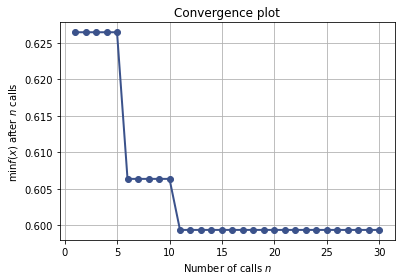

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "Ridge"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(Ridge, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from Ridge with dataset-2:  0.5933059966427705
CV RMSLE from Ridge with dataset-2:  0.5993546972144631


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### Lasso Regression (Linear Regression with L1 Regularization):

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for Lasso that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha")
]
param_names = [
    "alpha",
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
Lasso = partial(
    SGDRegressor,
    penalty='l1',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, Lasso, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 17.2250
Function value obtained: 0.5494
Current minimum: 0.5494
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 75.79547978890417}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.4489
Function value obtained: 0.7499
Current minimum: 0.5494
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.7488
Function value obtained: 0.5634
Current minimum: 0.5494
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.3822
Function value obtained: 0.7499
Current minimum: 0.5494
Iteration No: 5 started. Evaluating functi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 17.6465
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 22.603727905980342}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.6855
Function value obtained: 0.7499
Current minimum: 0.5280
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 17.6354
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 17.6869
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 17.6218
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 17.8035
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.03836445903514502}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 19.4357
Function value obtained: 0.6710
Current minimum: 0.5280
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 17.7759
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 2.5008358530693107}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.7631
Function value obtained: 0.7499
Current minimum: 0.5280
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 17.6982
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 17.7252
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 17.7915
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 17.6706
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 18.6836
Function value obtained: 0.5280
Current minimum: 0.5280
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 17.6464
Function value obtained: 0.5280
Current minimum: 0.5280


Best Hyperparams: {'alpha': 0.0001}


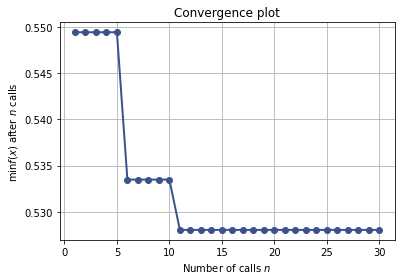

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "Lasso"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(Lasso, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from Lasso with dataset-2:  0.4980429358959019
CV RMSLE from Lasso with dataset-2:  0.528025134639519


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### Elastic Net (Linear Regression with L1 and L2 Regularization):

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for Elastic Net that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0.0001, 0.9999, prior="uniform", name="l1_ratio")
]
param_names = [
    "alpha",
    "l1_ratio"
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
ElasticNet = partial(
    SGDRegressor,
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, ElasticNet, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8398810539636506}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.9257
Function value obtained: 0.5448
Current minimum: 0.5448
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197, 'l1_ratio': 0.5692974651691941}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.8529
Function value obtained: 0.5516
Current minimum: 0.5448
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.11466571841722528, 'l1_ratio': 0.01884425904870172}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.3184
Function value obtained: 0.6208
Current minimum: 0.5448
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24793871956659042}
Iteration No: 4 ended. Evaluation done

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 11.2946
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010140384382282175, 'l1_ratio': 0.6001726367375818}
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.3183
Function value obtained: 0.5192
Current minimum: 0.4889
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.004249170640259883, 'l1_ratio': 0.9948475400790526}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.9337
Function value obtained: 0.5873
Current minimum: 0.4889
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 11.3223
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.2618
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.01085779366070226, 'l1_ratio': 0.002311142032012358}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.4782
Function value obtained: 0.5379
Current minimum: 0.4889
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.3500
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010047913773920307, 'l1_ratio': 0.09680080773344284}
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.7167
Function value obtained: 0.4983
Current minimum: 0.4889
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.3074
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 11.2625
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.3552
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0001}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 11.2269
Function value obtained: 0.4889
Current minimum: 0.4889


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0001}


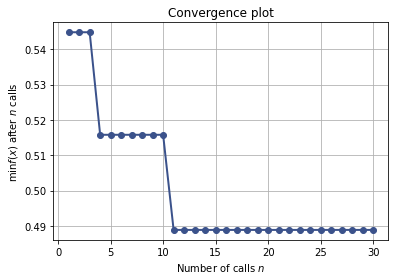

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "ElasticNet"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(ElasticNet, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from ElasticNet with dataset-2:  0.4560773177760247
CV RMSLE from ElasticNet with dataset-2:  0.4888712258636704


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### Huber Regression:

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for Huber Regressor that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(1.1, 10, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
HuberRegressor = partial(
    SGDRegressor,
    loss='huber',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, HuberRegressor, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 2.179824372726423}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.7052
Function value obtained: 0.5450
Current minimum: 0.5450
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 1.266857276988843}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.3031
Function value obtained: 0.7502
Current minimum: 0.5450
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 1.9326083274424637}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.0458
Function value obtained: 0.5160
Current minimum: 0.5160
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 7.307

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 11.1575
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.1405
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00013467945786931553, 'l1_ratio': 0.0, 'epsilon': 10.0}
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.6803
Function value obtained: 0.4898
Current minimum: 0.4889
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 936.402622972326, 'l1_ratio': 0.0020330740734650914, 'epsilon': 1.4826776572954674}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 16.4099
Function value obtained: 0.7500
Current minimum: 0.4889
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 11.2774
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.006528851794978984, 'l1_ratio': 0.003785038774603234, 'epsilon': 7.988124256665831}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.4796
Function value obtained: 0.5298
Current minimum: 0.4889
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.005015092886765414, 'l1_ratio': 0.9961532899919456, 'epsilon': 8.87187508583794}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.9157
Function value obtained: 0.5888
Current minimum: 0.4889
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.2539
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001034993358949648, 'l1_ratio': 0.5701767004065993, 'epsilon': 8.398329865958594}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 12.3084
Function value obtained: 0.5187
Current minimum: 0.4889
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.1976
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 11.2425
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.2399
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 11.0203
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.0712
Function value obtained: 0.4889
Current minimum: 0.4889
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 12.0100
Function value obtained: 0.4889
Current minimum: 0.4889


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 10.0}


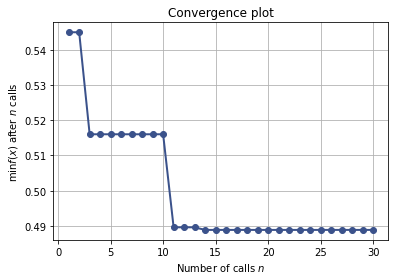

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "HuberRegressor"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(HuberRegressor, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from HuberRegressor with dataset-2:  0.45606156444905266
CV RMSLE from HuberRegressor with dataset-2:  0.48886181228000297


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### SGD Regressor with loss="epsilon_insensitive":

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for SGD_epsilon_insensitive that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(0.1, 2, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
SGD_epsilon_insensitive = partial(
    SGDRegressor,
    loss='epsilon_insensitive',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, SGD_epsilon_insensitive, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 0.33052430428991053}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.7823
Function value obtained: 0.5450
Current minimum: 0.5450
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 0.13562121643582042}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.9044
Function value obtained: 0.7531
Current minimum: 0.5450
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 0.27774784518434614}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.7214
Function value obtained: 0.5147
Current minimum: 0.5147
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha':

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 10.9394
Function value obtained: 0.4883
Current minimum: 0.4881
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.2505268883945054}
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.7556
Function value obtained: 0.4881
Current minimum: 0.4881
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 1.0, 'epsilon': 0.8546416189777976}
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.5876
Function value obtained: 0.5512
Current minimum: 0.4881
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0006543761569941408, 'l1_ratio': 0.0, 'epsilon': 0.4806936377069637}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.1626
Function value obtained: 0.4981


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1876287163414042}


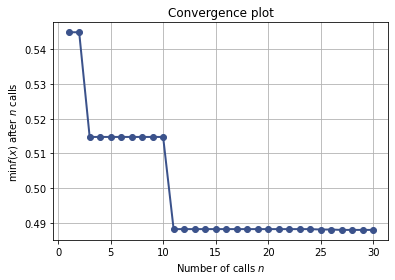

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "SGD_epsilon_insensitive"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(SGD_epsilon_insensitive, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from SGD_epsilon_insensitive with dataset-2:  0.45158172757852505
CV RMSLE from SGD_epsilon_insensitive with dataset-2:  0.48790736230440906


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### SGD Regressor with loss="squared_epsilon_insensitive":

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
# define a parameter space for SGD_sq_epsilon_insensitive that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
    space.Real(0, 1, prior="uniform", name="l1_ratio"),
    space.Real(0.1, 2, prior="uniform", name="epsilon")
]
param_names = [
    "alpha",
    "l1_ratio",
    "epsilon"
]

train_split = (X_tr_2, log_price_tr.values.ravel())
cv_split = (X_cv_2, price_cv.values.ravel())

# Model
SGD_sq_epsilon_insensitive = partial(
    SGDRegressor,
    loss='squared_epsilon_insensitive',
    penalty='elasticnet',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, SGD_sq_epsilon_insensitive, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464, 'l1_ratio': 0.8399490437724051, 'epsilon': 0.33052430428991053}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.1818
Function value obtained: 0.5448
Current minimum: 0.5448
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815, 'l1_ratio': 0.4370619423411273, 'epsilon': 0.13562121643582042}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.9332
Function value obtained: 0.7500
Current minimum: 0.5448
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.00019249309661403458, 'l1_ratio': 0.24788829722603561, 'epsilon': 0.27774784518434614}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.6848
Function value obtained: 0.5144
Current minimum: 0.5144
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 10.9510
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 17 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.8951
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 18 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.8950
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 19 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00010684063799922513, 'l1_ratio': 0.9507795881963071, 'epsilon': 0.16050481585994605}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 17.1538
Function value obtained: 0.5207
Current minimum: 0.4847
Iteration No: 20 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.8919
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 21 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.1359146888540782, 'l1_ratio': 0.9079643955004443, 'epsilon': 1.9973006584065958}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 16.4645
Function value obtained: 0.7893
Current minimum: 0.4847
Iteration No: 22 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.00011028735727520296, 'l1_ratio': 0.988174450326129, 'epsilon': 0.9825309224014092}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 17.5321
Function value obtained: 0.5928
Current minimum: 0.4847
Iteration No: 23 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.9018
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 24 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.002410387607092598, 'l1_ratio': 0.06731957728256378, 'epsilon': 0.12639832321454178}
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.0214
Function value obtained: 0.5298
Current minimum: 0.4847
Iteration No: 25 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.9356
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 26 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.9311
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 27 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.9663
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 28 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.8643
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 29 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.9874
Function value obtained: 0.4847
Current minimum: 0.4847
Iteration No: 30 started. Searching for the next optimal point.
Input Params:  {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.9634
Function value obtained: 0.4847
Current minimum: 0.4847


Best Hyperparams: {'alpha': 0.0001, 'l1_ratio': 0.0, 'epsilon': 0.1}


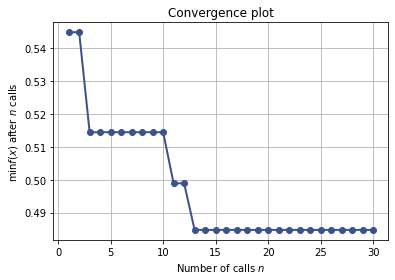

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
model_name = "SGD_sq_epsilon_insensitive"
ds2_model_best_params[model_name] = best_params
ds2_model_results[model_name] = get_results(SGD_sq_epsilon_insensitive, best_params, 
                                            train_split, cv_split)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from SGD_sq_epsilon_insensitive with dataset-2:  0.4479118449938892
CV RMSLE from SGD_sq_epsilon_insensitive with dataset-2:  0.4847354197129778


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

### Simple MLPs:
Ref: [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [ ]:
# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
def build_model(hp, params=None):
    inp = Input(shape=(X_tr_2.shape[1],), dtype='float32', sparse=True)
    
    if params is None:
        # Choose an optimal value between 32-256
        hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
        hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
        hp_units3 = hp.Int('units3', min_value=32, max_value=256, step=32)
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    else:
        hp_units1 = params['units1']
        hp_units2 = params['units2']
        hp_units3 = params['units3']
        hp_learning_rate = params['learning_rate']

    hidden_1 = Dense(units=hp_units1, kernel_initializer= 'he_uniform', 
                     activation='relu')(inp)
    hidden_2 = Dense(units=hp_units2, kernel_initializer= 'he_uniform', 
                     activation='relu')(hidden_1)
    hidden_3 = Dense(units=hp_units3, kernel_initializer= 'he_uniform', 
                     activation='relu')(hidden_2)
    out = Dense(1, kernel_initializer='normal', activation='linear')(hidden_3)
    mlp_ds2 = Model(inp, out)

    mlp_ds2.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='huber_loss',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return mlp_ds2

# BayesianOptimization algorithm from keras tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_rmse', direction="min"),
    max_trials=6,
    num_initial_points=3,
    seed=3,
    directory='mlp_ds2',
    project_name='Mercari_Price_Pred'
)

tuner.search(X_tr_2, log_price_tr.values.ravel(), epochs=3, batch_size=256,
             validation_data=(X_cv_2, np.log1p(price_cv.values)))

Trial 6 Complete [00h 02m 31s]
val_rmse: 0.44180071353912354

Best val_rmse So Far: 0.439481258392334
Total elapsed time: 00h 17m 30s


In [ ]:
print("Best Hyper params: ")
mlp_best_params = {}
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
    mlp_best_params[h_param] = tuner.get_best_hyperparameters()[0].get(h_param)
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

Best Hyper params: 
units1 224
units2 224
units3 64
learning_rate 0.0001


In [ ]:
# Can build using the build_model function 
mlp_ds2 = build_model(None, params=mlp_best_params)
mlp_ds2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 170890)]          0         
                                                                 
 dense_4 (Dense)             (None, 224)               38279584  
                                                                 
 dense_5 (Dense)             (None, 224)               50400     
                                                                 
 dense_6 (Dense)             (None, 64)                14400     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,344,449
Trainable params: 38,344,449
Non-trainable params: 0
_________________________________________________________________


**Note:** We can obtain the best model loaded with the weights corresponding to their best checkpoint using the "tuner.get_best_models()" method as shown below.

But it is officially recommended to retrain the model on the full dataset using the best hyperparameters found during search.

In [ ]:
mlp_ds2 = tuner.get_best_models()[0]
mlp_ds2.build(X_tr_2.shape)
mlp_ds2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170890)]          0         
                                                                 
 dense (Dense)               (None, 224)               38279584  
                                                                 
 dense_1 (Dense)             (None, 224)               50400     
                                                                 
 dense_2 (Dense)             (None, 64)                14400     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,344,449
Trainable params: 38,344,449
Non-trainable params: 0
_________________________________________________________________


Retraining the model with the best hyperparameters obtained from the search:

In [ ]:
# Build the model with the optimal hyperparameters and 
# train it on the data for 3 epochs
# mlp_ds2 = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
mlp_ds2.fit(
    X_tr_2, log_price_tr.values.ravel(), epochs=3, batch_size=256, 
    validation_data=(X_cv_2, np.log1p(price_cv.values)))

Epoch 1/3
4341/4341 [==============================] - 78s 17ms/step - loss: 0.0575 - rmse: 0.3430 - val_loss: 0.0927 - val_rmse: 0.4411
Epoch 2/3
4341/4341 [==============================] - 76s 17ms/step - loss: 0.0404 - rmse: 0.2869 - val_loss: 0.0949 - val_rmse: 0.4463
Epoch 3/3
4341/4341 [==============================] - 76s 17ms/step - loss: 0.0289 - rmse: 0.2423 - val_loss: 0.0975 - val_rmse: 0.4528


In [ ]:
mlp_ds2.save("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds2")

In [ ]:
mlp_ds2 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds2")

In [ ]:
model_name = "mlp_ds2"
ds2_model_best_params[model_name] = mlp_best_params

y_true_tr = np.expm1(log_price_tr.values.ravel())
y_pred_tr = np.abs(np.expm1(mlp_ds2.predict(X_tr_2)))
y_pred_cv = np.abs(np.expm1(mlp_ds2.predict(X_cv_2)))

ds2_model_results[model_name] = {}
ds2_model_results[model_name]["train"] = mean_squared_log_error(
                                        y_true_tr, y_pred_tr, squared=False)

ds2_model_results[model_name]["cv"] = mean_squared_log_error(
                              price_cv.values.ravel(), y_pred_cv, squared=False)

print(f"Train RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name} with dataset-2: ", 
        ds2_model_results[model_name]["cv"])

Train RMSLE from mlp_ds2 with dataset-2:  0.20688754826478872
CV RMSLE from mlp_ds2 with dataset-2:  0.4527927924862388


In [ ]:
# saving the results on dataset-2
joblib.dump(ds2_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
joblib.dump(ds2_model_best_params, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib']

# Results from different models trained above:

In [ ]:
# loading the results on dataset-1
ds1_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_results.joblib")
ds1_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds1_model_best_params.joblib")

# loading the results on dataset-2
ds2_model_results = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_results.joblib")
ds2_model_best_params = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ds2_model_best_params.joblib")

In [ ]:
results = {"Dataset-1": ds1_model_results, "Dataset-2": ds2_model_results}

x = PrettyTable()
x.field_names = ["Dataset", "Model", "Train RMSLE", "CV RMSLE"]
# print results in tabular format
for dataset in results:
    first_row = True
    for mdl in results[dataset]:
        dataset_name = dataset if first_row else ""
        model_name = mdl if ('mlp' not in mdl) else "MLP"
        first_row = False
        x.add_row(
            [dataset_name, model_name, results[dataset][mdl]["train"].round(3), 
             results[dataset][mdl]["cv"].round(3)])
    print(x)
    x.clear_rows()

+-----------+----------------------------+-------------+----------+
|  Dataset  |           Model            | Train RMSLE | CV RMSLE |
+-----------+----------------------------+-------------+----------+
| Dataset-1 |           Ridge            |    0.467    |  0.504   |
|           |           Lasso            |    0.531    |  0.569   |
|           |         ElasticNet         |    0.504    |  0.537   |
|           |       HuberRegressor       |    0.504    |  0.537   |
|           |  SGD_epsilon_insensitive   |     0.5     |  0.536   |
|           | SGD_sq_epsilon_insensitive |    0.492    |  0.526   |
|           |            MLP             |    0.331    |  0.437   |
+-----------+----------------------------+-------------+----------+
+-----------+----------------------------+-------------+----------+
|  Dataset  |           Model            | Train RMSLE | CV RMSLE |
+-----------+----------------------------+-------------+----------+
| Dataset-2 |           Ridge            |    0.

- **From the results we see that MLPs performed the best on both datasets.**

# Creating an ensemble of MLPs:
Producing a weighted average of results obtained from the above two MLPs trained on different featurizations of the dataset using a simple Ridge regressor.

**Generating predictions from MLP-1 trained on Dataset-1**(One-Hot encoded categories and shipping_id, Ordinal encoded item_condition_id + TFIDF encoded text with bigrams and other numerical features obtained from feature engineering):

In [ ]:
mlp_ds1 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds1")

y_pred_tr_mlp_ds1 = mlp_ds1.predict(X_tr_1)
y_pred_cv_mlp_ds1 = mlp_ds1.predict(X_cv_1)

**Generating predictions from MLP-2 trained on Dataset-2**(Target encoded categories and shipping_id, Ordinal encoded item_condition_id + BOW encoded text with bigrams and other numerical features obtained from feature engineering):

In [ ]:
mlp_ds2 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/mlp_ds2")

y_pred_tr_mlp_ds2 = mlp_ds2.predict(X_tr_2)
y_pred_cv_mlp_ds2 = mlp_ds2.predict(X_cv_2)

Stacking predictions for final meta model(Ridge regressor):

In [ ]:
X_tr_stack = np.hstack(
    (y_pred_tr_mlp_ds1.reshape(-1, 1), y_pred_tr_mlp_ds2.reshape(-1, 1)))
X_cv_stack = np.hstack(
    (y_pred_cv_mlp_ds1.reshape(-1, 1), y_pred_cv_mlp_ds2.reshape(-1, 1)))

Training the meta model(Ridge regressor):

In [ ]:
# define a parameter space for Ridge that's to be tuned by skopt
param_space = [
    space.Real(0.0001, 1000, prior="log-uniform", name="alpha"),
]
param_names = [
    "alpha",
]

train_split = (X_tr_stack, log_price_tr.values.ravel())
cv_split = (X_cv_stack, price_cv.values.ravel())

# Model
Ridge = partial(
    SGDRegressor,
    learning_rate='adaptive',
    random_state=3,
    early_stopping=True,
    n_iter_no_change=5
)

# tune model
result, best_params = tune_model(param_names, param_space, Ridge, 
                                 train_split, cv_split)

Iteration No: 1 started. Evaluating function at random point.
Input Params:  {'alpha': 0.000312661322166464}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.3103
Function value obtained: 0.4466
Current minimum: 0.4466
Iteration No: 2 started. Evaluating function at random point.
Input Params:  {'alpha': 75.79547978890417}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.5843
Function value obtained: 0.7433
Current minimum: 0.4466
Iteration No: 3 started. Evaluating function at random point.
Input Params:  {'alpha': 0.0007068057410793197}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.7211
Function value obtained: 0.4463
Current minimum: 0.4463
Iteration No: 4 started. Evaluating function at random point.
Input Params:  {'alpha': 0.9664497811178815}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.0935
Function value obtained: 0.5162
Current minimum: 0.4463
Iteration No: 5 started. Evaluating functio

Best Hyperparams: {'alpha': 0.10910420479772052}


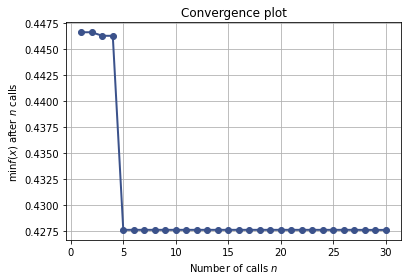

In [ ]:
plot_convergence(result)
print("Best Hyperparams:", best_params)

In [ ]:
meta_lr = Ridge(**best_params)
meta_lr.fit(X_tr_stack, log_price_tr.values.ravel())

SGDRegressor(alpha=0.10910420479772052, early_stopping=True,
             learning_rate='adaptive', random_state=3)

In [ ]:
ensemble_model_results = {}
model_name = "ensemble_of_mlps_with_LR"
ensemble_model_results[model_name] = meta_lr.get_params()

y_true_tr = np.expm1(log_price_tr.values.ravel())
y_pred_tr = np.abs(np.expm1(meta_lr.predict(X_tr_stack)))
y_pred_cv = np.abs(np.expm1(meta_lr.predict(X_cv_stack)))

ensemble_model_results[model_name] = {}
ensemble_model_results[model_name]["train"] = mean_squared_log_error(
                                        y_true_tr, y_pred_tr, squared=False)
ensemble_model_results[model_name]["cv"] = mean_squared_log_error(
                              price_cv.values.ravel(), y_pred_cv, squared=False)

print(f"Train RMSLE from {model_name}: ", 
      ensemble_model_results[model_name]["train"])
print(f"CV RMSLE from {model_name}: ", 
      ensemble_model_results[model_name]["cv"])

joblib.dump(ensemble_model_results, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ensemble_model_results.joblib")

Train RMSLE from ensemble_of_mlps_with_LR:  0.231445292903701
CV RMSLE from ensemble_of_mlps_with_LR:  0.42762473351615987


['/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/ensemble_model_results.joblib']

**Weights assigned to predictions from MLPs trained on Dataset-1 and Dataset-2 in the final ensemble**:

In [ ]:
print("Weightage of prediction from MLP trained on Dataset-1:", meta_lr.coef_[0])
print("Weightage of prediction from MLP trained on Dataset-2:", meta_lr.coef_[1])

Weightage of prediction from MLP trained on Dataset-1: 0.3474315896546436
Weightage of prediction from MLP trained on Dataset-2: 0.5926249117926982


Saving the trained meta model(Ridge regressor):

In [ ]:
# save
filename = 'meta_lr.pkl'
joblib.dump(meta_lr, "/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/"+filename)

# load
# meta_lr = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-1-MERCARI/models/meta_lr.pkl")

# Evaluating the model's performance on unseen test data: (Submission to kaggle):

The score comes out to be 0.42903 placing it at position 205 out of 2381 entries. ie; among the top 8%.

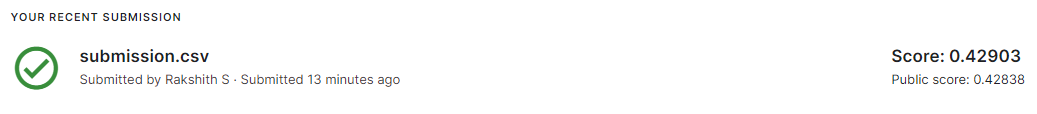

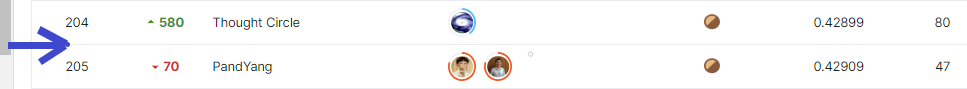

**Note:** The resource and runtime constraints imposed during the kaggle challenge were not taken into consideration in this case study.